# Applying Clustering Machine Learning to environment

notebook by _Kara Ponder (UC Berkeley)_, _Alex Malz (GCCL@RUB)_, _Ben Moews (Edinburgh)_, _Stephen Thorp (Cambridge)_, add your name here

In [1]:
from astropy.io import fits
import corner
import environment as galenv
import glob
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import pandas as pd
import pickle
import pystan
import scipy.optimize as spo
from scipy.stats import multivariate_normal
from tslearn.clustering import TimeSeriesKMeans

np.seed = 42

In [2]:
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

We want to get the spectra of galaxies matching conditions found [here](http://www.gama-survey.org/dr3/schema/table.php?id=31).

In [3]:
with fits.open('SpecObj.fits') as hdul:
    hdul.info()
#     print(hdul[1].header)
    zdf = pd.DataFrame(np.array(hdul[1].data).byteswap().newbyteorder())
    print(zdf.columns)
#     df.index = df['CATAID']

Filename: SpecObj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (3919,)   uint8   
  1  SpecObj       1 BinTableHDU    106   160026R x 19C   [J, 23A, I, I, I, E, 33A, 9A, I, D, D, E, D, E, I, E, 67A, 88A, 92A]   
Index(['CATAID', 'GAMA_NAME', 'IC_FLAG', 'N_SPEC', 'N_GAMA_SPEC', 'DIST',
       'SPECID', 'SURVEY', 'SURVEY_CODE', 'RA', 'DEC', 'WMIN', 'WMAX', 'Z',
       'NQ', 'PROB', 'FILENAME', 'URL', 'URL_IMG'],
      dtype='object')


GAMA did calculate some environment measures for us, but only on a small subset of galaxies.

In [4]:
# with fits.open('EnvironmentMeasures.fits') as hdul:
#     hdul.info()
# #     print(hdul[1].header)
#     envdf = pd.DataFrame(np.array(hdul[1].data).byteswap().newbyteorder())
#     print(envdf.columns)
# #     envdf.index = envdf['CATAID']

In [ ]:
# df = pd.merge(envdf, zdf, on='CATAID')
df = zdf

## Select spectra by redshift and field

Each galaxy in the GAMA catalog has a spectroscopically confirmed redshift.  
We're going to match these redshifts to the snapshots of the particle data.

Add in a cutoff at lowest redshift at 0.023 and highest at 3.066
- Came to this by what the distance is between 0.042 and it's upper endpoint
- Added an upper cutoff as well of 3.066 (by same way for equal redshift space on either side)

Idea: could also split bins by median redshift between endpoints and then cutoffs for highest and lowest redshifts in the dataset.

[0.023  0.061  0.105  0.1755 0.269  0.3675 0.4715 0.5825 0.702  0.8305
 0.969  1.12   1.2855 1.467  1.667  1.8895 2.138  2.417  2.732  3.066 ]


Text(0, 0.5, 'number of galaxies')

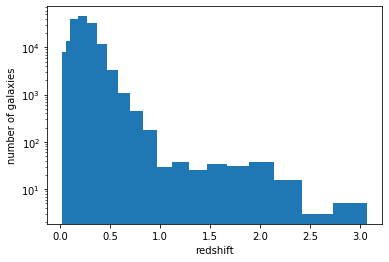

In [5]:
z_SLICS = np.array([0.042, 0.080, 0.130, 0.221, 0.317, 0.418, 0.525, 0.640, 0.764, 0.897, 
           1.041, 1.199, 1.372, 1.562, 1.772, 2.007, 2.269, 2.565, 2.899])
z_mids = (z_SLICS[1:] + z_SLICS[:-1]) / 2.
z_bins = np.insert(z_mids, 0, 0.023)
z_bins = np.append(z_bins, 3.066)
print(z_bins)
plt.hist(zdf['Z'], bins=z_bins)
plt.semilogy()
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
#plt.savefig('redshift_dist_GAMA_cat.png')

In [6]:
jet = plt.cm.Spectral_r #plt.cm.get_cmap('viridis_r')
cNorm  = colors.Normalize(vmin=z_SLICS[0], vmax=z_SLICS[13])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
color=scalarMap.to_rgba(z_SLICS)

The histogram of redshift is skewed by the use of `z=10` as a placeholder for not having a secure redshift.  
GAMA has a quality flag we can use to filter for redshifts that were considered of sufficient quality for science use, which they define as `NQ > 2`.

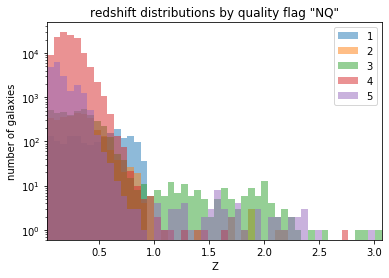

In [7]:
moar_bins = np.arange(z_bins[0], z_bins[-1] + z_bins[1], z_bins[1])
for i in range(5):
    quality = zdf.loc[zdf['NQ'] == i+1, 'Z']
    plt.hist(quality, alpha=0.5, label=str(i+1), bins=moar_bins)
plt.legend(loc='upper right')
plt.semilogy()
plt.xlim(moar_bins[0], moar_bins[-1])
plt.xlabel('Z')
plt.ylabel('number of galaxies')
plt.title('redshift distributions by quality flag "NQ"')
plt.savefig('redshift_dist_GAMA_nq.png')

GAMA observed galaxies in four disjoint regions of the sky.
Since environment is about the immediate vicinity of each galaxy, we'll have to divide the galaxies by region, effectively building our redshift-environment-color distribution separately for each region before combining those findings.

In [ ]:
corner.corner(np.array([df['RA'], df['DEC']]).T, labels=['RA', 'DEC'], show_titles=True)
plt.savefig('corner_ra_dec.png')

In [ ]:
RA_bin_ends = [0., 80., 160., 200., 360.]
subsamples, lens = [], []
for j in range(len(z_bins)-1):
    for i in range(len(RA_bin_ends)-1):
        subsample = df.loc[(df['RA'] >= RA_bin_ends[i]) & (df['RA'] < RA_bin_ends[i+1]) 
                             & (df['NQ'] > 2) & (df['Z'] >= z_bins[j]) & (df['Z'] < z_bins[j+1]), 
                             ['CATAID', 'RA', 'DEC', 'Z', 'NQ']]
        nn = len(subsample)
        if nn > 0:
            lens.append(nn)
            subsamples.append(subsample)

In [ ]:
print(lens)

In [ ]:
np.shape(subsample)

In [ ]:
chosen_field = np.argmax(lens)
print(chosen_field)

In [ ]:
datum = np.vstack((subsamples[chosen_field]['DEC'], [subsamples[chosen_field]['RA']])).T

## Number of neighbors within a distance

Within each field, we can quantify the density of the local region around each galaxy, which is really what the notion of "galaxy environment" is getting at.
We're going to use the number of neighboring galaxies at each of several given distances in angular coordinates, so as not to incur the computational cost of calculating the distances between all galaxies.

In [ ]:
help(galenv)

### Choose some reasonable radii

Our angular positions are in degrees.
The distances will be in bogus units because the code normalizes to the radius of the Earth, but we only need the number of neighbors within an angular distance, so it should be fine.

In [ ]:
chosen_ind = np.random.randint(0, len(datum), 1)[0]
print(chosen_ind)
try_distances = np.flip(np.geomspace(0.01, 1.0, 10), axis=0)
res = []
friends = datum
for dist in try_distances:
    friends = galenv.nn_finder(friends, datum[chosen_ind], dist)
    res.append(len(friends) - 1)

In [ ]:
plt.plot(try_distances, res)
plt.xlabel('distance in angular coordinates')
plt.ylabel('number of neighbors within distance')
plt.savefig('num_neighbors_example.png')

### Examine distribution of environment values

In [8]:
zenvdf = pd.read_csv('enviros.csv')

In [ ]:
#zenvdf 

Now we have the number of neighbors for all galaxies!

It remains to be seen whether the multimodal distributions in some bins are physical or not.
(They look like a problem with smoothing over a discrete variable.)
We'll try plotting them as a function of field and redshift next.
But either way, this doesn't really show the trends in idividual galaxy environment curves.

## Constructing the redshift-environment-color relationship

In [9]:
def redshift_df(str_zbin):
    r_files = glob.glob('SpecObjPhot/SpecObjPhot*.csv')
    f = [s for s in r_files if str_zbin in s]
    phodf = pd.read_csv(f[0])
    phodf = phodf.drop(columns=['GAMA_NAME', 'IC_FLAG', 
                            'N_SPEC', 'N_GAMA_SPEC', 'DIST', 
                            'SPECID', 'SURVEY', 'SURVEY_CODE',
                            'RA', 'DEC', 'WMIN', 'WMAX', 'Z', 'NQ',
                            'PROB', 'FILENAME', 'URL', 'URL_IMG'])
    df = pd.merge(phodf, zenvdf, on=['CATAID'])
    return df
    

In [ ]:
df_0042 = redshift_df('0.042')
df = df_0042

In [ ]:
### whichdata = ['Z']
corner.corner(np.array([df['RA'], df['DEC']]).T, labels=['RA', 'DEC'], show_titles=True)

In [17]:
#z_SLICS
try_distances = np.flip(np.geomspace(0.01, 1.0, 10), axis=0)
orig_distances = np.flip(try_distances, axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
#plt.figure(figsize=(15, 15))
for n, z in enumerate(z_SLICS):
    df = redshift_df(str(z))
    if len(df) > 0:
        for i in range(len(orig_distances)):
            parts = ax.violinplot(df[str(orig_distances[i])], positions=[i], vert=False)
            np.where(df[str(orig_distances[i])] < 1)
            c = color[n]
            for pc in parts['bodies']:
                pc.set_facecolor(c)
                pc.set_edgecolor(c)
                pc.set_alpha(0.5)
            
            parts['cbars'].set_color(c)
            parts['cbars'].set_alpha(0.7)
            
            parts['cmaxes'].set_color(c)
            parts['cmaxes'].set_alpha(0.7)
            
            parts['cmins'].set_color(c)
            parts['cmins'].set_alpha(0.7)
    else:
        print("I have nothing for you at n=%s, z=%s"%(n,z))



plt.yticks(range(len(orig_distances)), np.around(orig_distances, 3))
ax.semilogx()
ax.set_ylabel('radial distance [deg]', size=15)
ax.set_xlabel('number of neighbors', size=15)

cax, _ = matplotlib.colorbar.make_axes(ax, pad=0.01)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=jet, norm=cNorm)
cbar.ax.set_ylabel('redshift', size=12)
#plt.ylim(0.99, 10)

#plt.savefig('spectral_violinplot_neighbor_v_distance.jpeg')

In [ ]:
df = redshift_df(str(z_SLICS[1]))
for i in range(len(orig_distances)):
    dist = str(orig_distances[i])

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(df.loc[(df['lsstz'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstr']  
                - df.loc[(df['lsstz'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lssti'],
               df.loc[(df['lsstz'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lssti']  
                - df.loc[(df['lsstz'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstz'],
                c=df.loc[(df['lsstz'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)][dist].values,
                cmap=plt.cm.Spectral, #'viridis_r',
                vmin=1.0,
                vmax=max(df['1.0']),
                norm=matplotlib.colors.LogNorm(),
               alpha=0.4)

    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('Nearest Neighbors', size=12)
    plt.xlabel('r-i', size=15)
    plt.ylabel('i-z', size=15)
    plt.ylim(-2, 2)
    plt.title('dist = %s' %dist)
#    plt.savefig('ri_iz_dist_%s.png'%dist)

This all establishes that the number of neighbors does increase with distance in a given redshift bin, but it doesn't appear to strongly depend on color, otherwise we'd see gradients here.

for index, row in df_0042.iterrows():
    #print(index)
    #if index < 100:
    dist = [str(i) for i in orig_distances]
    plt.plot(orig_distances, row[dist], 'ok', alpha=0.5)
plt.xlabel('radial distance')
plt.ylabel('# neighbors')

# Time series clustering 

In [10]:
df_0042 = redshift_df('0.080')
df_0042.columns

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'CATAID', 'lsstg', 'lsstg_err', 'lsstr',
       'lsstr_err', 'lssti', 'lssti_err', 'lsstz', 'lsstz_err', 'lssty',
       'lssty_err', 'sdssr', 'sdssr_err', 'sdssi', 'sdssi_err', 'sdssz',
       'sdssz_err', 'Unnamed: 0_y', '1.0', '0.5994842503189409',
       '0.3593813663804626', '0.21544346900318834', '0.1291549665014884',
       '0.0774263682681127', '0.046415888336127774', '0.027825594022071243',
       '0.016681005372000592', '0.01', 'GAMA_NAME', 'IC_FLAG', 'N_SPEC',
       'N_GAMA_SPEC', 'DIST', 'SPECID', 'SURVEY', 'SURVEY_CODE', 'RA', 'DEC',
       'WMIN', 'WMAX', 'Z', 'NQ', 'PROB', 'FILENAME', 'URL', 'URL_IMG'],
      dtype='object')

In [11]:
X = df_0042.loc[(df_0042['lsstr'] > 0) & (df_0042['lssti'] > 0) & (df_0042['lsstz'] > 0), 
                [#'lsstg', 'lsstg_err', 
                 #'lsstr', 'lsstr_err', 
                 #'lssti', 'lssti_err', 
                 #'lsstz', 'lsstz_err', 
                 #'lssty', 'lssty_err',
                 '1.0', '0.5994842503189409',
                 '0.3593813663804626', '0.21544346900318834', 
                 '0.1291549665014884', '0.0774263682681127', 
                 '0.046415888336127774', '0.027825594022071243',
                 '0.016681005372000592', '0.01']].values

df_0042 = df_0042.loc[(df_0042['lsstr'] > 0) & (df_0042['lssti'] > 0) & (df_0042['lsstz'] > 0)]

In [ ]:
km_orig = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0).fit(X)

In [ ]:
km_orig.cluster_centers_.shape

In [ ]:
km_dba = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5,
                          max_iter_barycenter=5,
                           random_state=0).fit(X)

In [ ]:
km_dba.cluster_centers_.shape

In [ ]:
km_sdtw = TimeSeriesKMeans(n_clusters=3, metric="softdtw", max_iter=5,
                            max_iter_barycenter=5,
                            metric_params={"gamma": .5},
                            random_state=0).fit(X)

In [ ]:
wh_1, = np.where(km_orig.labels_ == 0)
wh_2, = np.where(km_orig.labels_ == 1)
wh_3, = np.where(km_orig.labels_ == 2)

In [ ]:
plt.plot(df_0042.iloc[wh_1]['lsstr']-df_0042.iloc[wh_1]['lssti'],
         df_0042.iloc[wh_1]['lssti']-df_0042.iloc[wh_1]['lsstz'], 
         'o', alpha=0.4, label='1st Cluster')

plt.plot(df_0042.iloc[wh_2]['lsstr']-df_0042.iloc[wh_2]['lssti'],
         df_0042.iloc[wh_2]['lssti']-df_0042.iloc[wh_2]['lsstz'],
         'o', alpha=0.2, label='2nd Cluster')

plt.plot(df_0042.iloc[wh_3]['lsstr']-df_0042.iloc[wh_3]['lssti'],
         df_0042.iloc[wh_3]['lssti']-df_0042.iloc[wh_3]['lsstz'],
         'o', alpha=0.1, label='3rd Cluster')

#plt.xlim(-2, 6)
#plt.ylim(-2, 3)

plt.xlabel('r-i')
plt.ylabel('i-z')
plt.legend()

The clusters seem to have the same mean, but the variance looks like it changes.

In [12]:
## Increase number of clusters 
# TBD: intelligently pick a number of cluxters
km = TimeSeriesKMeans(n_clusters=10, metric="euclidean", max_iter=5, random_state=0).fit(X)

1169.885 --> 896.897 --> 881.341 --> 874.443 --> 871.122 --> 


In [ ]:
# dump model to pickle so we can call it later
#redshift dependent
os.makedirs('ts_kmeans', exist_ok=True)
filename = 'ts_kmeans/tskmeans_0.080.pkl'
pickle.dump(km, open(filename, 'wb'))

In [13]:
df_0042['label'] = km.labels_

In [14]:
df_0042['r-i'] = df_0042['lsstr']-df_0042['lssti']
df_0042['i-z'] = df_0042['lssti']-df_0042['lsstz']

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [26]:
# Create only the input data columns for Slack
new = df_0042[['r-i', 'i-z', 'lsstr', 'label']]
#new.to_csv('colors_lsstr_label_0080.csv')
#new

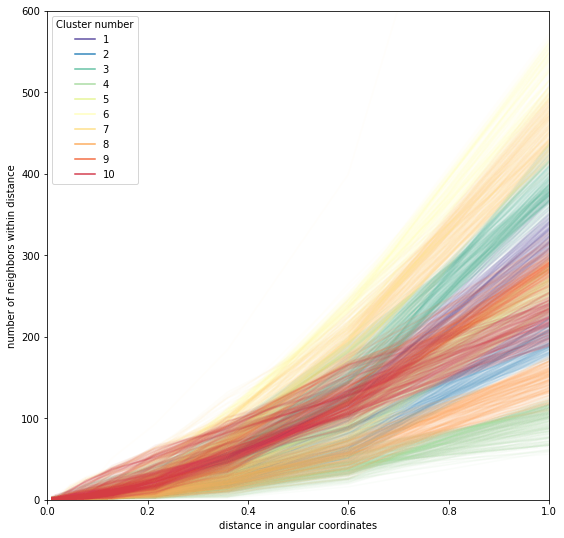

In [29]:
wh_1, = np.where(km.labels_ == 0)
wh_2, = np.where(km.labels_ == 1)
wh_3, = np.where(km.labels_ == 2)
wh_4, = np.where(km.labels_ == 3)
wh_5, = np.where(km.labels_ == 4)
wh_6, = np.where(km.labels_ == 5)
wh_7, = np.where(km.labels_ == 6)
wh_8, = np.where(km.labels_ == 7)
wh_9, = np.where(km.labels_ == 8)
wh_10, = np.where(km.labels_ == 9)

x = [str(i) for i in try_distances]


cNorm  = colors.Normalize(vmin=0, vmax=10)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
color=scalarMap.to_rgba(np.arange(0, 10, 1))

plt.figure(figsize=(9,9))
for vals in df_0042.iloc[wh_1][x].values[0:200]:
#    print(vals, try_distances)
    plt.plot(try_distances, vals, color=color[0], alpha=0.05) #.columns.values
    
for vals in df_0042.iloc[wh_2][x].values[0:200]:
    plt.plot(try_distances, vals, color=color[1], alpha=0.05) #.columns.values

for vals in df_0042.iloc[wh_3][x].values[0:300]:
    plt.plot(try_distances, vals, color=color[2], alpha=0.05) #.columns.values
    
for vals in df_0042.iloc[wh_4][x].values[0:300]:
    plt.plot(try_distances, vals, color=color[3], alpha=0.05) #.columns.values
    
for vals in df_0042.iloc[wh_5][x].values[0:300]:
    plt.plot(try_distances, vals, color=color[4], alpha=0.05) #.columns.values
    
for vals in df_0042.iloc[wh_6][x].values[0:300]:
    plt.plot(try_distances, vals, color=color[5], alpha=0.05) #.columns.values
    
for vals in df_0042.iloc[wh_7][x].values[0:300]:
    plt.plot(try_distances, vals, color=color[6], alpha=0.05) #.columns.values

for vals in df_0042.iloc[wh_8][x].values[0:300]:
    plt.plot(try_distances, vals, color=color[7], alpha=0.05) #.columns.values
    
for vals in df_0042.iloc[wh_9][x].values[0:300]:
    plt.plot(try_distances, vals, color=color[8], alpha=0.05) #.columns.values
    
for vals in df_0042.iloc[wh_10][x].values[0:300]:
    plt.plot(try_distances, vals, color=color[9], alpha=0.05) #.columns.values
    

plt.axhline(-5, color=color[0], label='1') 
plt.axhline(-5, color=color[1], label='2') 
plt.axhline(-5, color=color[2], label='3') 
plt.axhline(-5, color=color[3], label='4') 
plt.axhline(-5, color=color[4], label='5') 
plt.axhline(-5, color=color[5], label='6') 
plt.axhline(-5, color=color[6], label='7') 
plt.axhline(-5, color=color[7], label='8') 
plt.axhline(-5, color=color[8], label='9') 
plt.axhline(-5, color=color[9], label='10') 

plt.ylim(0, 600)
plt.xlim(0, 1)
plt.legend(loc=2, title='Cluster number')

plt.xlabel('distance in angular coordinates')
plt.ylabel('number of neighbors within distance')

#plt.savefig('environment_with_labels.png')

In [ ]:
plt.figure(figsize=(10,8))
for f in range(0, 10):
    #print(f)
    wh_1, = np.where(km.labels_ == f)
    #print(len(wh_1))
    sc = plt.scatter(df_0042.iloc[wh_1]['lsstr']-df_0042.iloc[wh_1]['lssti'],
                df_0042.iloc[wh_1]['lssti']-df_0042.iloc[wh_1]['lsstz'], 
                alpha=0.3, #label='%s Cluster' %f,
                c=[f]*len(wh_1),  #c=df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)][dist].values
                cmap=plt.cm.Spectral, #'viridis_r',
                vmin=0,
                vmax=10)
                #norm=matplotlib.colors.LogNorm())

cbar = plt.colorbar(sc, pad=0.01)
cbar.ax.set_ylabel('Label', size=12)
plt.xlim(-1.5, 2)
plt.ylim(-1.5, 2)

plt.ylabel('i-z', size=15)
plt.xlabel('r-i', size=15)
#plt.legend()
plt.savefig('colors_with_labels_0080.png')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for f in range(0, 10):
    wh_1, = np.where(km.labels_ == f)
    data = np.array([df_0042.iloc[wh_1]['lsstr']-df_0042.iloc[wh_1]['lssti'],
                df_0042.iloc[wh_1]['lssti']-df_0042.iloc[wh_1]['lsstz']])
    mean = np.mean(data, axis=-1)
    cov = np.cov(data)
    evec = np.linalg.eig(cov)[-1][-1]
    t = np.degrees(np.arctan2(evec[0], evec[1]))
    ax.scatter(mean[0], mean[1], color=plt.cm.Spectral(f / 10.), label=str(f), marker='.', s=10)
    ellipse = Ellipse(xy=(mean[0], mean[1]), width=2.*np.sqrt(cov[0, 0]), height=2.*np.sqrt(cov[1, 1]), angle=t,
                     alpha=0.2, color=plt.cm.Spectral(f / 10.))
    ax.add_artist(ellipse) 
ax.set_xlim(0., 1.)
ax.set_ylim(0., 0.5)
plt.legend()
plt.ylabel('i-z', size=15)
plt.xlabel('r-i', size=15)
#plt.savefig('colors_per_environment_class.png')

These don't look so distinct to me, but maybe I'm making a mistake. . .

In [ ]:
df = df_0042
fig = corner.corner(np.array([df.loc[(km.labels_ == 0)]['lsstr'], 
                        df.loc[(km.labels_ == 0)]['lssti'],
                        df.loc[(km.labels_ == 0)]['lsstz'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstg_err'], 
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstr_err'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lssti_err']
                       ]).T, 
              labels=['r', 'i', 'z'], show_titles=True, color=color[-1], plot_density=False,
              plot_contours=False,
              quantiles=[0.16, 0.84])

corner.corner(np.array([df.loc[(km.labels_ == 4)]['lsstr'], 
                        df.loc[(km.labels_ == 4)]['lssti'],
                        df.loc[(km.labels_ == 4)]['lsstz'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstg_err'], 
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstr_err'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lssti_err']
                       ]).T, 
              labels=['r', 'i', 'z'], show_titles=True, color=color[12], fig=fig, plot_density=False, 
              plot_contours=False,
              quantiles=[0.16, 0.84])

corner.corner(np.array([df.loc[(km.labels_ == 9)]['lsstr'], 
                        df.loc[(km.labels_ == 9)]['lssti'],
                        df.loc[(km.labels_ == 9)]['lsstz'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstg_err'], 
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstr_err'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lssti_err']
                       ]).T, 
              labels=['r', 'i', 'z'], show_titles=True, color=color[4], fig=fig, plot_density=False, 
              plot_contours=False, lw=3,
              quantiles=[0.16, 0.84])


# Extract the axes
#axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
#for i in range(ndim):
#    ax = axes[i, i]
#    ax.axvline(value1[i], color="g")
#    ax.axvline(value2[i], color="r")
#fig.savefig('tsclustering.png')

In [ ]:
df = df_0042
fig = corner.corner(np.array([df.loc[(km.labels_ == 0)]['lsstr']- df.loc[(km.labels_ == 0)]['lssti'], 
                        df.loc[(km.labels_ == 0)]['lssti']-df.loc[(km.labels_ == 0)]['lsstz'],
                        df.loc[(km.labels_ == 0)]['lsstr'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstg_err'], 
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstr_err'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lssti_err']
                       ]).T, 
              labels=['r-i', 'i-z', 'r'], show_titles=True, color=color[-1], plot_density=False,
             range = [(-1.,1.6), (-1.6,1.6),(15,21)],
              plot_contours=False,
              quantiles=[0.16,0.84])

corner.corner(np.array([df.loc[(km.labels_ == 4)]['lsstr']-df.loc[(km.labels_ == 4)]['lssti'], 
                        df.loc[(km.labels_ == 4)]['lssti']-df.loc[(km.labels_ == 4)]['lsstz'],
                        df.loc[(km.labels_ == 4)]['lsstr'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstg_err'], 
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstr_err'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lssti_err']
                       ]).T, 
              labels=['r-i', 'i-z', 'r'], show_titles=True, color=color[12], fig=fig, plot_density=False,
              range = [(-1.,1.6), (-1.6,1.6),(15,21)],
              plot_contours=False,
              quantiles=[0.16, 0.84])

corner.corner(np.array([df.loc[(km.labels_ == 9)]['lsstr']-df.loc[(km.labels_ == 9)]['lssti'], 
                        df.loc[(km.labels_ == 9)]['lssti']-df.loc[(km.labels_ == 9)]['lsstz'],
                        df.loc[(km.labels_ == 9)]['lsstr'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstg_err'], 
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lsstr_err'],
                        #df.loc[(df['lsstg'] > 0) & (df['lsstr'] > 0) & (df['lssti'] > 0)]['lssti_err']
                       ]).T, 
              labels=['r-i', 'i-z', 'r'], show_titles=True, color=color[4], fig=fig, plot_density=False, 
              range = [(-1.,1.6), (-1.6,1.6),(15,21)],
              plot_contours=False, lw=3,
              quantiles=[0.16, 0.84])


# Extract the axes
#axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
#for i in range(ndim):
#    ax = axes[i, i]
#    ax.axvline(value1[i], color="g")
#    ax.axvline(value2[i], color="r")
#fig.savefig('tsclustering_color.png')

## Generate 3D Multivariate normal 

Notes:
tavy_resampled is drawing `N_resamples` number of samples from our distribution. If the standard deviation on the mu's and Sigma's are low, then stats.multivariate_normal is fine. If there are large errors, then the tavy_resampled take these errors into account when drawing. 

mu_trans, sigma, L_Omega, L_Sigma, Omega are by-products of the fits. There can be nan's in L_Omega and L_Sigma as they are triangle matrices.

mu[1, 2, 3] = 3 means
Sigma[] = covariance matrix

In [ ]:
df = pd.read_csv('colors_lsstr_label_0080.csv')

In [ ]:
df_l = df.loc[df['label']==1]

In [ ]:
N = len(df_l)

vals = df_l[[ 'r-i', 'i-z', 'lsstr']].values

N_re = 1

dat = {
    'N': N,
    'D': 3,
    'N_resamples': N_re,
    'tavy': vals,
}

In [ ]:
## You only need this ONE model to fix all of the data no matter what label or redshift you have!
try:
    sm = pickle.load(open('3D_Gaussian_model.pkl', 'rb'))
except:
    sm = pystan.StanModel(file='some_dimensional_gaussian.stan')

In [ ]:
# Save the model so that you don't have to keep regenerating it. 
with open('3D_Gaussian_model.pkl', 'wb') as f:
    pickle.dump(sm, f)

In [ ]:
fit = sm.sampling(data=dat, iter=1000, chains=4, warmup=500) 

In [ ]:
print(fit.stansummary())

In [ ]:
summary = pd.DataFrame(fit.summary(pars=['mu', 'Sigma'])['summary'], 
             columns=fit.summary(pars=['mu', 'Sigma'])['summary_colnames'])

In [ ]:
summary['Names'] = fit.summary(pars=['mu', 'Sigma'])['summary_rownames']

In [ ]:
os.makedirs('fit_summaries', exist_ok=True)
summary.to_csv('fit_summaries/summary_0.080_label_9.csv') ## 
summary

In [ ]:
mus = summary.iloc[:3]['mean'].values

plt.figure()
plt.hist(df_l['r-i'], bins=np.arange(-0.5, 1.5, 0.15), alpha=0.5, label='r-i')
plt.hist(df_l['i-z'], bins=np.arange(-0.5, 1.5, 0.15), alpha=0.5, label='i-z')
#plt.hist(df_l['i-z'])

plt.axvline(mus[0], color='k')
plt.axvline(mus[1], color='k')
plt.legend()

plt.figure()
plt.hist(df_l['lsstr'], label='lsstr')

plt.axvline(mus[2], color='k')
plt.legend()
###plt.savefig('means_per_color.png')

## Since the means are so well defined, we will use scipy to draw random values

In [ ]:
summary = pd.read_csv('fit_summaries/summary_0.080_label_9.csv')

mus = summary.iloc[:3]['mean'].values
cov = summary.iloc[3:]['mean'].values.reshape(3, 3)

rando = multivariate_normal.rvs(mus, cov)

In [ ]:
plt.figure()
plt.hist(df_l['r-i'], bins=np.arange(-0.5, 1.5, 0.15), color=color[-5], alpha=0.5, label='r-i')
plt.hist(df_l['i-z'], bins=np.arange(-0.5, 1.5, 0.15), color=color[0], alpha=0.5, label='i-z')
#plt.hist(df_l['i-z'])

plt.axvline(mus[0], color='k', label='fit means')
plt.axvline(mus[1], color='k')

plt.axvline(rando[0], color='grey', lw=5, alpha=0.5, label='Random Draw')
plt.axvline(rando[1], color='grey', lw=5, alpha=0.5)
plt.xlabel('color [mag]')
plt.legend()
#plt.savefig('random_draw_color.png')

plt.figure()
plt.hist(df_l['lsstr'], color=color[10], label='lsstr')

plt.axvline(mus[2], color='k', label='fit means')

plt.axvline(rando[2], color='grey', alpha=0.5, lw=5, label='Random Draw')
plt.xlabel('lsstr [mag]')
plt.legend()
plt.savefig('random_draw_lsstr.png')